In [16]:
from kafka import KafkaProducer
from kafka import KafkaConsumer
import pandas as pd
import json
import time
import re
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the data
df = pd.read_csv("feedback_data.csv")

Step 1:Data Ingestion

In [ ]:
# Initialize Kafka producer
producer = KafkaProducer(
    bootstrap_servers='localhost:9092',
    value_serializer=lambda v: json.dumps(v).encode('utf-8')  # Convert to JSON and encode as bytes
)

# Send data to Kafka topic
for _, row in df.iterrows():
    data = row.to_dict()  # Convert each row to a dictionary
    producer.send('feedback_topic', value=data)  # Send data to the topic
    print(f"Sent: {data}")
    time.sleep(1)  # Simulate real-time data ingestion with a delay

# Close the producer
producer.close()

In [ ]:
# Initialize Kafka consumer
consumer = KafkaConsumer(
    'feedback_topic',
    bootstrap_servers='localhost:9092',
    auto_offset_reset='earliest',
    value_deserializer=lambda x: json.loads(x.decode('utf-8'))  # Decode bytes to JSON
)

# Process messages from the Kafka topic
print("Listening for messages from Kafka...")
for message in consumer:
    feedback = message.value  # Get the message value (feedback data)
    print(f"Received: {feedback}")

Step 2:Data Cleaning

In [6]:
# Fill missing comments with placeholder text
df['Comment'] = df['Comment'].fillna('No Comment')

In [7]:
# Basic text preprocessing
def clean_text(text):
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text)  # Remove extra whitespaces
    text = text.lower()  # Convert to lowercase
    return text

In [8]:
df['Comment'] = df['Comment'].apply(clean_text)

In [9]:
df['Rating'] = df['Rating'].fillna(df['Rating'].mean())

Step 3:Sentiment Analysis

In [10]:
# Function to determine sentiment polarity
def get_sentiment(text):
    if text == 'No Comment':
        return 'Neutral'
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    if polarity > 0:
        return 'Positive'
    elif polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

In [11]:
df['Sentiment'] = df['Comment'].apply(get_sentiment)

Step 4:Trend Analysis

In [12]:
# Convert Date column to datetime format for trend analysis
df['Date'] = pd.to_datetime(df['Date'])

In [13]:
df['Month'] = df['Date'].dt.to_period('M')
monthly_sentiment = df.groupby(['Month', 'Sentiment']).size().unstack(fill_value=0)

In [14]:
# Calculate average ratings per channel
channel_avg_rating = df.groupby('Feedback Channel')['Rating'].mean()

In [15]:
# Sentiment per channel
channel_sentiment_counts = df.groupby(['Feedback Channel', 'Sentiment']).size().unstack(fill_value=0)

Step 5:Data Visualization

C:\Users\Pandu\AppData\Local\Temp\ipykernel_16908\558285214.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Sentiment', palette="coolwarm")


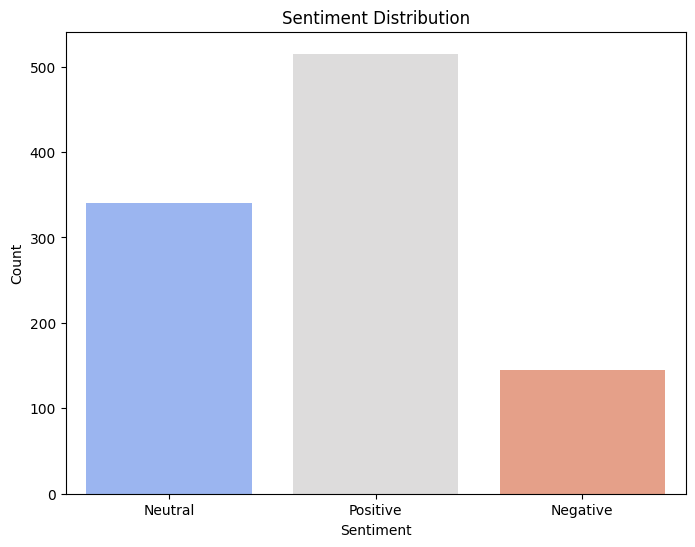

In [17]:
# Sentiment distribution plot
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Sentiment', palette="coolwarm")
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [18]:
# Extract month and year for trend analysis
df['Month'] = df['Date'].dt.to_period('M')


In [19]:
# Count feedback per month for each sentiment
monthly_sentiment = df.groupby(['Month', 'Sentiment']).size().unstack(fill_value=0)

<Figure size 1200x600 with 0 Axes>

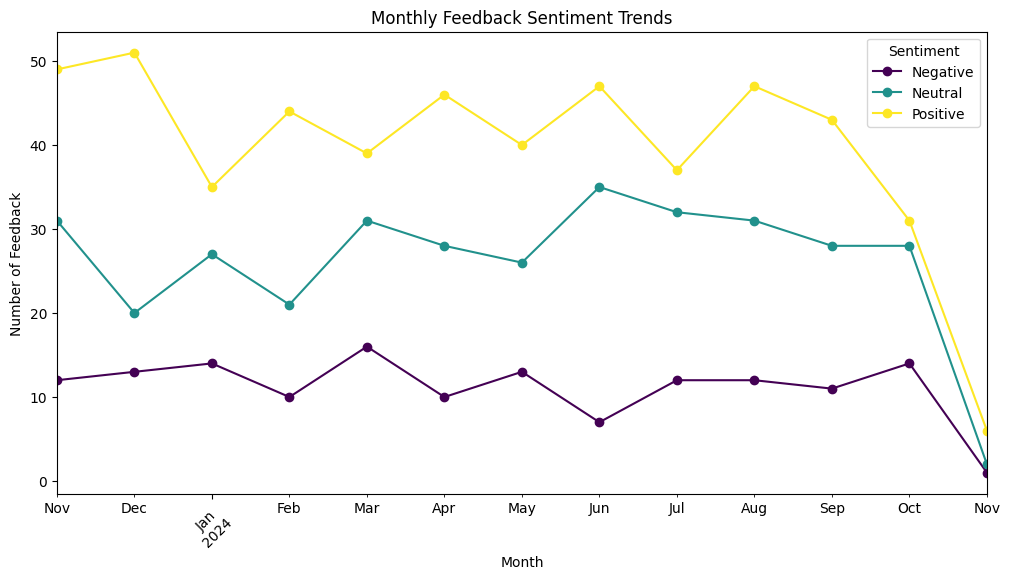

In [20]:
# Plot trends over time
plt.figure(figsize=(12, 6))
monthly_sentiment.plot(kind='line', marker='o', figsize=(12, 6), colormap="viridis")
plt.title('Monthly Feedback Sentiment Trends')
plt.xlabel('Month')
plt.ylabel('Number of Feedback')
plt.legend(title="Sentiment")
plt.xticks(rotation=45)
plt.show()

In [21]:
# Calculate the average rating per channel
channel_avg_rating = df.groupby('Feedback Channel')['Rating'].mean()

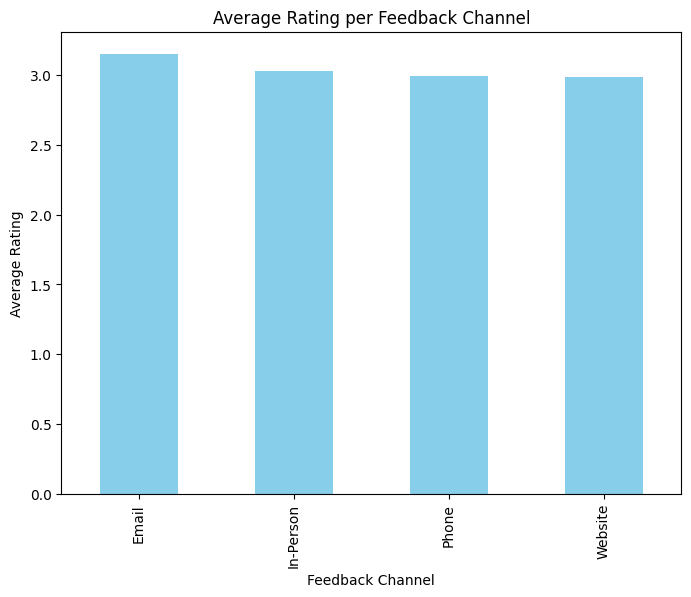

In [22]:
# Plot average rating per feedback channel
plt.figure(figsize=(8, 6))
channel_avg_rating.plot(kind='bar', color='skyblue')
plt.title('Average Rating per Feedback Channel')
plt.xlabel('Feedback Channel')
plt.ylabel('Average Rating')
plt.show()

In [23]:
# Count of each sentiment per channel
channel_sentiment_counts = df.groupby(['Feedback Channel', 'Sentiment']).size().unstack(fill_value=0)

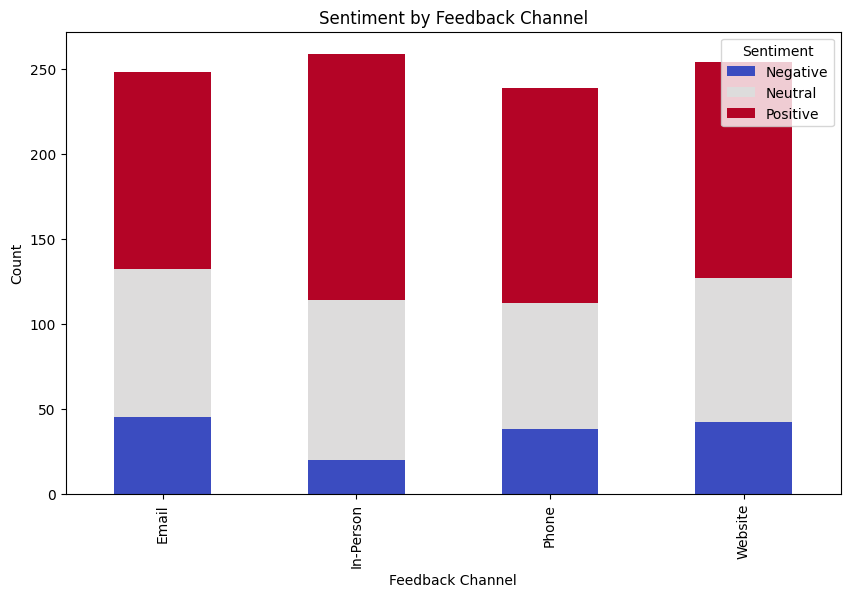

In [24]:
# Plot sentiment distribution by channel
channel_sentiment_counts.plot(kind='bar', stacked=True, figsize=(10, 6), colormap="coolwarm")
plt.title('Sentiment by Feedback Channel')
plt.xlabel('Feedback Channel')
plt.ylabel('Count')
plt.legend(title="Sentiment")
plt.show()